In [2]:
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt 

from numpy.random import default_rng
rng = default_rng(seed=1234)

In [3]:
from masterthesis.data import load_h5ad

# load the python AnnData object
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/simdata.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/germ_sce.h5ad")
anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/COVAC_POSTQC.h5ad")

# Preprocessing

In [3]:
from masterthesis.preprocessing import Preprocessing

# do not log transform
# do not normalize
# use all genes after filtering for low mean counts
pp = Preprocessing(scale=True, normalize=True, select_genes="all")
anndata = pp.fit_transform(anndata)

In [4]:
from masterthesis.preprocessing import calculate_weights, transform_labels
from sklearn.model_selection import train_test_split

anndata.obs["ordinal_label"] = transform_labels(np.array([int(x) for x in anndata.obs.donor_age]))
X_train, X_test, y_train, y_test = train_test_split(anndata.X, anndata.obs["ordinal_label"], 
                                                    test_size=0.1, 
                                                    stratify=anndata.obs["ordinal_label"],
                                                    random_state=1234)

In [5]:
from masterthesis.model_selection import RegularizationGridSearch
from masterthesis.model import SGDBinarizedModel, LinearBinarizedModel
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, log_loss

reg_params = np.geomspace(1, 100, 20)
#reg_params = np.geomspace(1, 0.001, 20)
weights_train = calculate_weights(y_train)
scoring = make_scorer(accuracy_score)
fit_params = {"sample_weight": weights_train}
estimator_params = None #{"max_iter": 20}

fit_params = {}
estimator_params = {}

lin = RegularizationGridSearch(estimator=LinearBinarizedModel, n_folds=5, n_jobs=5, lambdas=reg_params, scoring=scoring)
lin.fit(X_train, y_train, fit_params=fit_params, estimator_params=estimator_params)

Best idx: 7 Best Score: 0.6448352462051092 Best Lambda: 5.455594781168519 Scores std: 0.1551641038314406
1SE idx: 6 1SE Score: 0.6393187708256202 1SE Lambda: 4.281332398719393


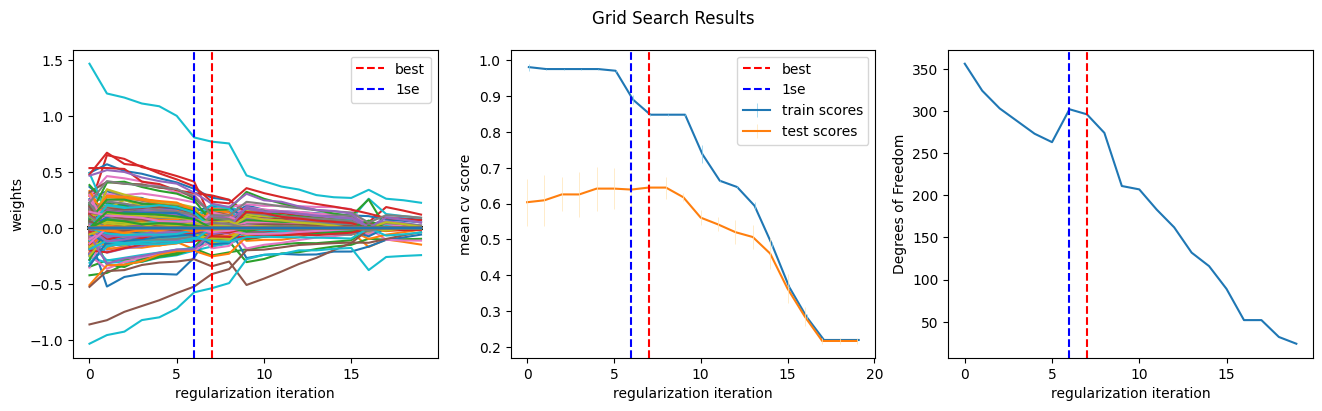

In [6]:
from masterthesis.plots import plot_grid_search
_ = plot_grid_search(lin)

In [7]:
sparse_model = lin.get_optimal_model("1se")
sparse_model.fit(X_train, y_train)

LinearBinarizedModel(regularization=4.281332398719393)

Degrees of freedom 299
Train:
Accuracy: 0.9539295392953929
Balanced accuracy: 0.842741935483871
Mean absolute delta: 0.01415358141535814
Test:
Accuracy: 0.6666666666666666
Balanced accuracy: 0.554301948051948
Mean absolute delta: 0.4493243243243243


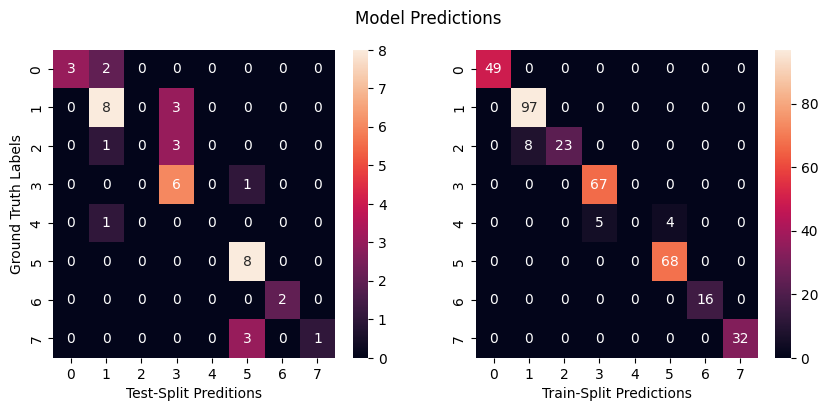

In [8]:
from masterthesis.plots import plot_model_perf
_ = plot_model_perf(sparse_model, test=(X_test, y_test), train=(X_train, y_train))

In [9]:
sparse_model.predict_psuper(anndata)
anndata.var["psupertime_weights"] = sparse_model.coef_

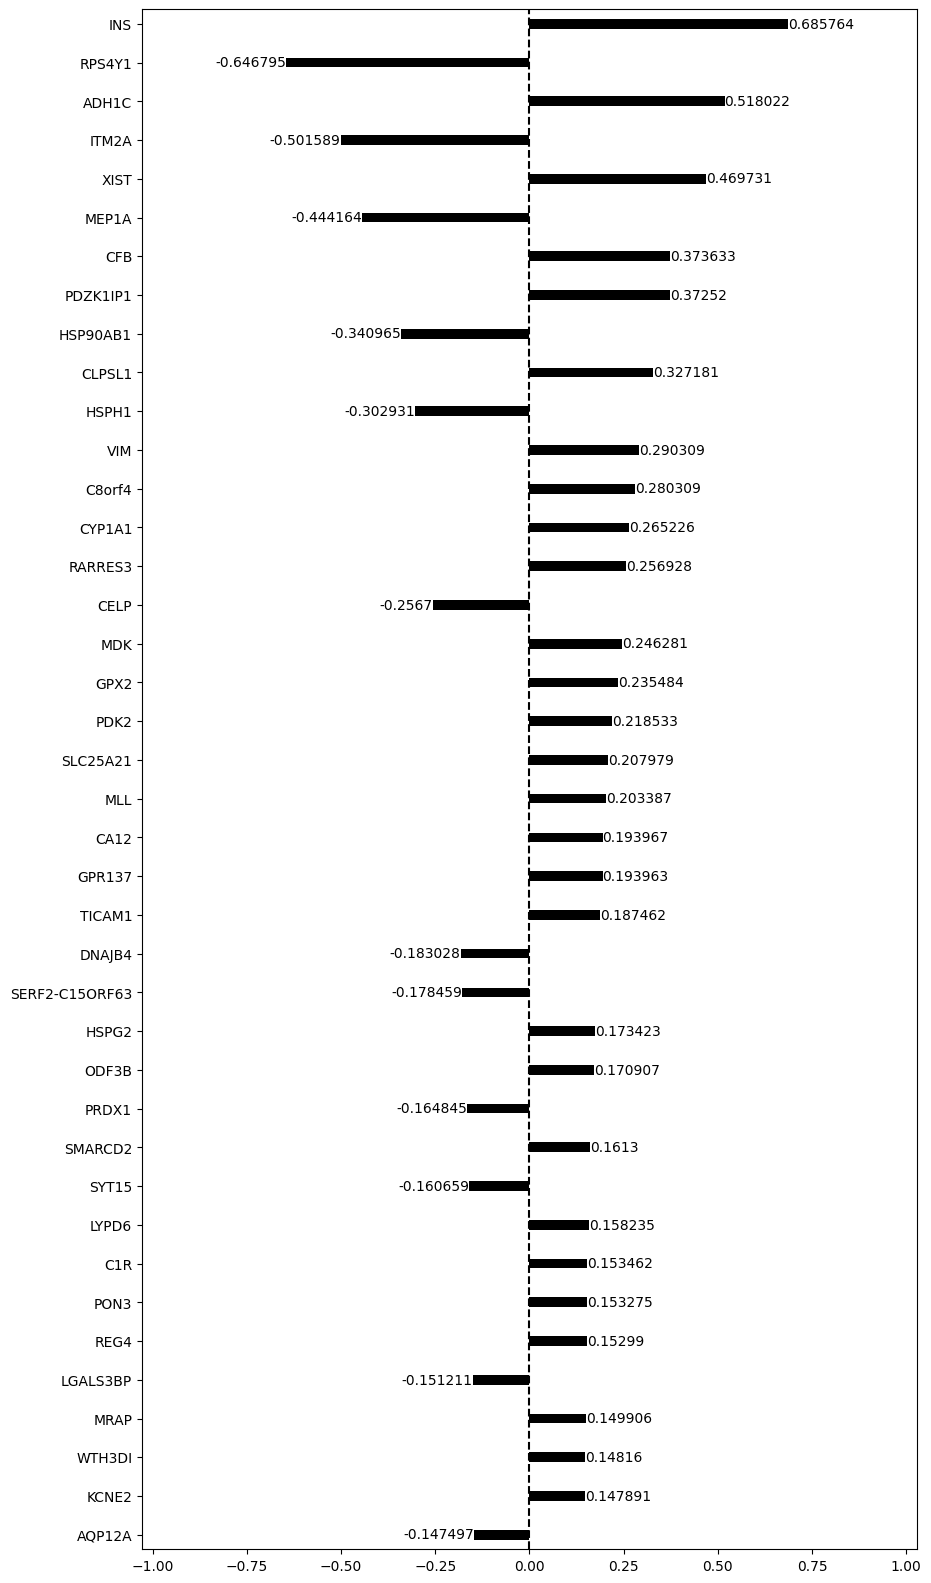

In [10]:
from masterthesis.plots import plot_identified_gene_coefficients

_ = plot_identified_gene_coefficients(sparse_model, anndata, n_top=40, figsize=(10,20))

# Significant Genes

In [11]:
PY_GENES = anndata.var[anndata.var["psupertime_weights"] != 0].index

In [12]:
# > dput(as.character(pobj_all$beta_dt[pobj_all$beta_dt$beta != 0]$symbol))
R_GENES = ["INS", "ELF3", "RAP2A", "MLLT6", "HSP90AA1", "RXRB", "EFEMP2", 
"PTP4A3", "ZNF862", "NFKB1", "C18orf1", "TMEM234", "LOC285441", 
"ERCC2", "ITM2A", "MTA3", "SCGB1C1", "STAB2", "IREB2", "NOTCH4", 
"CYB5D2", "SS18", "ASB3", "PODXL", "FAM135A", "SNORA76", "JMJD5", 
"AS3MT", "AKIRIN2", "MFN2", "SMURF2", "GATAD1", "AHSA2", "C4orf47", 
"GATSL3", "SLC2A10", "RNU12", "LOC389247", "SNORD54", "PPY", 
"SERPINA3", "CFLAR.AS1", "FAM20C", "ELP4", "VTRNA1.3", "SLCO2B1", 
"SGCE", "SGK1", "LOC399715", "SNORA80B", "RNF186", "DHX8", "TTC28", 
"ZBTB17", "C10orf54", "C14orf21", "C21orf119", "CELF5", "TMEM194A", 
"EPN2", "LOC100306975", "SNORA9", "MADD", "LOC285758", "ARVCF", 
"KIAA1383", "NECAB1", "SPEF2", "SNORD63", "WDR20", "TMEM229B", 
"CYS1", "C16orf89", "GAD1", "SYT15", "OXCT1", "ONECUT1", "PEX5L", 
"ATE1", "ULK3", "PEG3", "SNORA80", "CDC14B", "TDH", "C4orf32", 
"MMP24", "AACS", "GALNT1", "STS", "AHDC1", "ETNK2", "FUZ", "ZNF317", 
"AZGP1", "ABCF1", "DLL1", "PANK1", "DUSP4", "UBAP2", "MIR4712"]

In [13]:
sum([g in PY_GENES for g in R_GENES]) / len(R_GENES)

0.12

In [14]:
sparse_model.binary_estimator_

LogisticRegression(C=0.23357214690901226, max_iter=10000, penalty='l1',
                   random_state=1234, solver='liblinear')

# Plot labels over psupertime

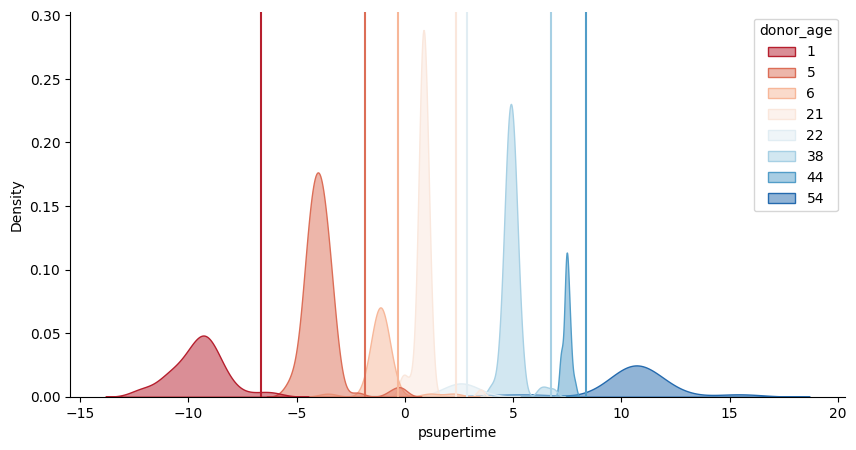

In [16]:
from masterthesis.plots import plot_labels_over_psupertime

_ = plot_labels_over_psupertime(sparse_model, anndata, "donor_age")
